In [ ]:
%pip install pandas scikit-learn
%pip install pycaret --quiet

In [ ]:
from pycaret.classification import *
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

# <> Bibliotecas de Visualização
import seaborn as sns
from matplotlib.pyplot import figure as pltfigure
import matplotlib.pyplot as plt

# <> Biliotecas para manipulação com dados
import pandas as pd

In [ ]:
# Carregar o dataset de partidas (Match.csv)
matches = pd.read_csv('Match.csv')

# Carregar o dataset de times (Team.csv)
teams = pd.read_csv('Team.csv')

# Carregar o dataset de ligas (League.csv)
leagues = pd.read_csv('League.csv')


In [ ]:
leagues.head()
#print(leagues['name'].unique())

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [ ]:
# Filtrar a Premier League
selectedLeagues = leagues[leagues['name'].isin(['England Premier League', 'Italy Serie A', 'Germany 1. Bundesliga'])]
selectedLeaguesId = selectedLeagues['id'].values

In [ ]:
#Filtrar as partidas de Match apenas para as ligas de interessa
filteredMatches = matches[matches['league_id'].isin(selectedLeaguesId)]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


In [ ]:
# Verificar colunas para identificar quais são de interesse
matches.columns
# teams.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [1]:
# Unir dados apenas das colunas importantes em um único df, tanto de Matches quanto Teams
filteredMatches = filteredMatches[['season','date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'league_id']]

selectedTeams = teams[['team_api_id', 'team_long_name']]

# Unindo informações dos times com as partidas (separando entre times da casa e fora, pois para cada partida, deve conter duas entradas: um para time da casa e outro para visitante)
mergedDataHome = pd.merge(filteredMatches, selectedTeams, how='left', left_on='home_team_api_id', right_on='team_api_id')
mergedDataHome.rename(columns={'team_long_name': 'home_team_name'}, inplace=True) #Renomeando para explicitar o nome do time da casa
mergedDataHome.drop('team_api_id', axis=1, inplace=True) #Retirando a coluna pois é reduntante, pois já tem no data frame

mergedData = pd.merge(mergedDataHome, selectedTeams, how='left', left_on='away_team_api_id', right_on='team_api_id')
mergedData.rename(columns={'team_long_name': 'away_team_name'}, inplace=True)
mergedData.drop('team_api_id', axis=1, inplace=True)

NameError: name 'filteredMatches' is not defined

In [ ]:
mergedDataHome.head()
mergedData.head()

mergedDataHome.dtypes

,0
season,object
date,object
home_team_api_id,int64
away_team_api_id,int64
home_team_goal,int64
away_team_goal,int64
league_id,int64
home_team_name,object


In [ ]:
# Calcular gols marcados e sofridos por cada time e adicionar à tabela
def calculate_goals(df):
    df['home_goals_scored'] = df['home_team_goal']
    df['home_goals_conceded'] = df['away_team_goal']

    df['away_goals_scored'] = df['away_team_goal']
    df['away_goals_conceded'] = df['home_team_goal']

    return df

mergedData = calculate_goals(mergedData)

In [ ]:
# Agrupar para somar os gols totais por time

# Agrupar por time e temporada para somar os gols marcados e sofridos
homeGoal = mergedData.groupby(['season', 'home_team_name'])[['home_goals_scored', 'home_goals_conceded']].sum().reset_index()
awayGoals = mergedData.groupby(['season', 'away_team_name'])[['away_goals_scored', 'away_goals_conceded']].sum().reset_index()

# Renomear colunas para facilitar a junção
homeGoal.rename(columns={'home_team_name': 'team_name'}, inplace=True)
awayGoals.rename(columns={'away_team_name': 'team_name'}, inplace=True)

# Combinar os gols de casa e fora em uma única tabela
totalGoals = pd.merge(homeGoal, awayGoals, on=['season', 'team_name'], how='outer')

# Somar os gols marcados e sofridos
totalGoals['goals_scored'] = totalGoals['home_goals_scored'] + totalGoals['away_goals_scored']
totalGoals['goals_conceded'] = totalGoals['home_goals_conceded'] + totalGoals['away_goals_conceded']

# Manter apenas as colunas de interesse
totalGoals = totalGoals[['season', 'team_name', 'goals_scored', 'goals_conceded']]


In [ ]:
#Adicionar gols marcados e sofridos ao dataframe principal, para os times da casa e visitates
mergedData = pd.merge(mergedData, totalGoals, how='left', left_on=['season', 'home_team_name'], right_on=['season', 'team_name'])
mergedData.rename(columns={'goals_scored': 'home_goals_scored_total', 'goals_conceded': 'home_goals_conceded_total'}, inplace=True)
mergedData.drop('team_name', axis=1, inplace=True)

# Adicionar os gols marcados e sofridos pelos times visitantes
mergedData = pd.merge(mergedData, totalGoals, how='left', left_on=['season', 'away_team_name'], right_on=['season', 'team_name'])
mergedData.rename(columns={'goals_scored': 'away_goals_scored_total', 'goals_conceded': 'away_goals_conceded_total'}, inplace=True)
mergedData.drop('team_name', axis=1, inplace=True)


In [ ]:
mergedData.head()


,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,league_id,home_team_name,away_team_name,home_goals_scored,home_goals_conceded,away_goals_scored,away_goals_conceded,home_goals_scored_total,home_goals_conceded_total,away_goals_scored_total,away_goals_conceded_total
0,2008/2009,2008-08-17 00:00:00,10260,10261,1,1,1729,Manchester United,Newcastle United,1,1,1,1,68,24,40,59
1,2008/2009,2008-08-16 00:00:00,9825,8659,1,0,1729,Arsenal,West Bromwich Albion,1,0,0,1,68,37,36,67
2,2008/2009,2008-08-16 00:00:00,8472,8650,0,1,1729,Sunderland,Liverpool,0,1,1,0,34,54,77,27
3,2008/2009,2008-08-16 00:00:00,8654,8528,2,1,1729,West Ham United,Wigan Athletic,2,1,1,2,42,45,34,45
4,2008/2009,2008-08-17 00:00:00,10252,8456,4,2,1729,Aston Villa,Manchester City,4,2,2,4,54,48,58,50


In [2]:
# Calcular pontos para cada time em cada temporada

# 3 pontos por vitória, 1 ponto por empate, 0 por derrota
mergedData['home_team_points'] = mergedData.apply(lambda x: 3 if x['home_team_goal'] > x['away_team_goal'] else (1 if x['home_team_goal'] == x['away_team_goal'] else 0), axis=1)
mergedData['away_team_points'] = mergedData.apply(lambda x: 3 if x['away_team_goal'] > x['home_team_goal'] else (1 if x['away_team_goal'] == x['home_team_goal'] else 0), axis=1)

# Agrupar por temporada e time para somar os pontos totais
homePoints = mergedData.groupby(['season', 'home_team_name'])['home_team_points'].sum().reset_index()
awayPoints = mergedData.groupby(['season', 'away_team_name'])['away_team_points'].sum().reset_index()

# Renomear colunas para facilitar o merge
homePoints.rename(columns={'home_team_name': 'team_name', 'home_team_points': 'points'}, inplace=True)
awayPoints.rename(columns={'away_team_name': 'team_name', 'away_team_points': 'points'}, inplace=True)

# Combinar os pontos de casa e fora em uma única tabela
totalPoints = pd.merge(homePoints, awayPoints, on=['season', 'team_name'], how='outer')
totalPoints['totalPoints'] = totalPoints['points_x'] + totalPoints['points_y']

# Manter apenas as colunas de interesse
totalPoints = totalPoints[['season', 'team_name', 'totalPoints']]

# Identificar o time campeão de cada temporada
champions = totalPoints.loc[totalPoints.groupby('season')['totalPoints'].idxmax()]
champions['is_champion'] = 1


NameError: name 'mergedData' is not defined

In [ ]:
# Adicionar a coluna 'is_champion' ao dataframe original
mergedData = pd.merge(mergedData, champions[['season', 'team_name', 'is_champion']], how='left', left_on=['season', 'home_team_name'], right_on=['season', 'team_name'])

# Preencher os valores NaN da coluna 'is_champion' com 0 (para os times que não foram campeões)
mergedData['is_champion'].fillna(0, inplace=True)

# Remover a coluna 'team_name' que veio do merge
mergedData.drop('team_name', axis=1, inplace=True)


In [ ]:
# Dividir entre dados de treino e teste

from sklearn.model_selection import train_test_split

# Selecionar as features (X) e a variável alvo (y)
X = mergedData[['home_goals_scored_total', 'home_goals_conceded_total', 'away_goals_scored_total', 'away_goals_conceded_total', 'is_champion']]  # Ajuste as features de acordo com seus dados
# y = mergedData['is_champion']

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, = train_test_split(X, test_size=0.2, random_state=123)


In [ ]:
mergedData.shape
mergedData.head()

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,league_id,home_team_name,away_team_name,home_goals_scored,home_goals_conceded,away_goals_scored,away_goals_conceded,home_goals_scored_total,home_goals_conceded_total,away_goals_scored_total,away_goals_conceded_total,home_team_points,away_team_points,is_champion
0,2008/2009,2008-08-17 00:00:00,10260,10261,1,1,1729,Manchester United,Newcastle United,1,1,1,1,68,24,40,59,1,1,1.0
1,2008/2009,2008-08-16 00:00:00,9825,8659,1,0,1729,Arsenal,West Bromwich Albion,1,0,0,1,68,37,36,67,3,0,0.0
2,2008/2009,2008-08-16 00:00:00,8472,8650,0,1,1729,Sunderland,Liverpool,0,1,1,0,34,54,77,27,0,3,0.0
3,2008/2009,2008-08-16 00:00:00,8654,8528,2,1,1729,West Ham United,Wigan Athletic,2,1,1,2,42,45,34,45,3,0,0.0
4,2008/2009,2008-08-17 00:00:00,10252,8456,4,2,1729,Aston Villa,Manchester City,4,2,2,4,54,48,58,50,3,0,0.0


In [ ]:
#Configurando o setup
cdt = setup(data=X_train,
            target='is_champion',
            test_data=X_test,
            session_id=123,
            index=False)

,Description,Value
0,Session id,123
1,Target,is_champion
2,Target type,Binary
3,Original data shape,"(8333, 5)"
4,Transformed data shape,"(8333, 5)"
5,Transformed train set shape,"(6666, 5)"
6,Transformed test set shape,"(1667, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [ ]:
models()

# Comparar os modelos e encontrar o melhor
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9958,0.9987,0.8712,0.9095,0.8824,0.8803,0.8844,0.2320
gbc,Gradient Boosting Classifier,0.9957,0.9997,0.8878,0.8898,0.8812,0.8790,0.8829,0.7550
xgboost,Extreme Gradient Boosting,0.9955,0.9993,0.8712,0.8930,0.8749,0.8726,0.8763,0.0910
lightgbm,Light Gradient Boosting Machine,0.9955,0.9997,0.8712,0.8930,0.8749,0.8726,0.8763,0.7900
dt,Decision Tree Classifier,0.9954,0.9428,0.8635,0.8918,0.8709,0.8686,0.8720,0.0320
rf,Random Forest Classifier,0.9952,0.9988,0.8558,0.8910,0.8663,0.8639,0.8675,0.3210
et,Extra Trees Classifier,0.9951,0.9430,0.8474,0.8908,0.8590,0.8565,0.8616,0.2390
lda,Linear Discriminant Analysis,0.9836,0.9750,0.4359,0.6103,0.4975,0.4895,0.5021,0.0540
lr,Logistic Regression,0.9817,0.9829,0.2327,0.5120,0.3133,0.3057,0.3328,0.9720
ridge,Ridge Classifier,0.9814,0.9750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0390


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
#

rfModel = create_model('rf', n_estimators=100, max_depth=10, min_samples_split=2, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9948,0.9986,0.8400,0.8750,0.8571,0.8545,0.8547
1,0.9947,0.9992,0.8750,0.8400,0.8571,0.8545,0.8547
2,0.9955,0.9996,0.8800,0.8800,0.8800,0.8777,0.8777
3,0.9955,0.9995,0.8400,0.9130,0.8750,0.8727,0.8735
4,0.9947,0.9994,0.8800,0.8462,0.8627,0.8601,0.8602
Mean,0.9950,0.9993,0.8630,0.8708,0.8664,0.8639,0.8642
Std,0.0004,0.0004,0.0189,0.0262,0.0094,0.0096,0.0097


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

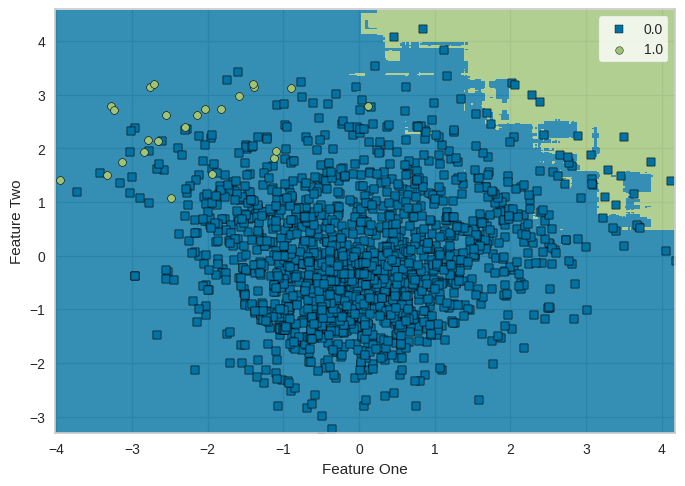

In [ ]:
plot_model(rfModel, plot='boundary')

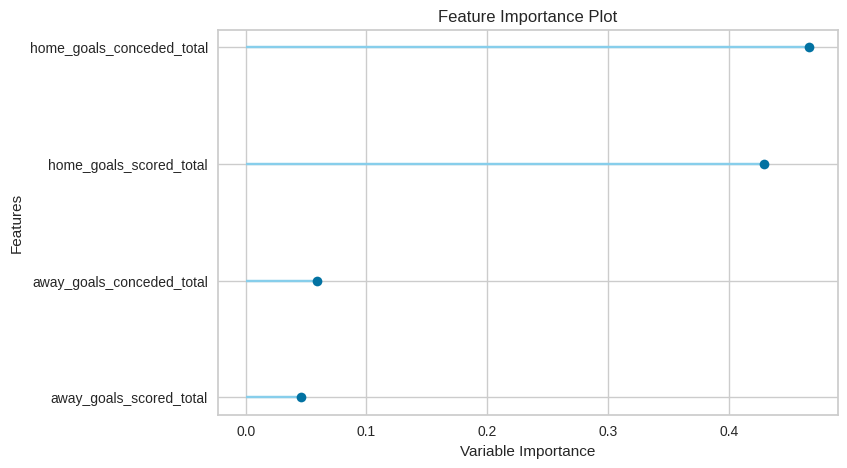

In [ ]:
plot_model(rfModel, plot='feature')

In [ ]:
#Realizar predição
rfTestingPred = predict_model(rfModel, data=X_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9970,0.9998,0.9167,0.8800,0.8980,0.8964,0.8966


In [ ]:
# Verificando como ficou a predição das observações
rfTestingPred.head()

,home_goals_scored_total,home_goals_conceded_total,away_goals_scored_total,away_goals_conceded_total,is_champion,prediction_label,prediction_score
0,46,52,27,84,0.0,0,1.0
1,47,62,52,39,0.0,0,1.0
2,51,45,43,70,0.0,0,1.0
3,17,33,40,20,0.0,0,1.0
4,30,60,75,39,0.0,0,1.0


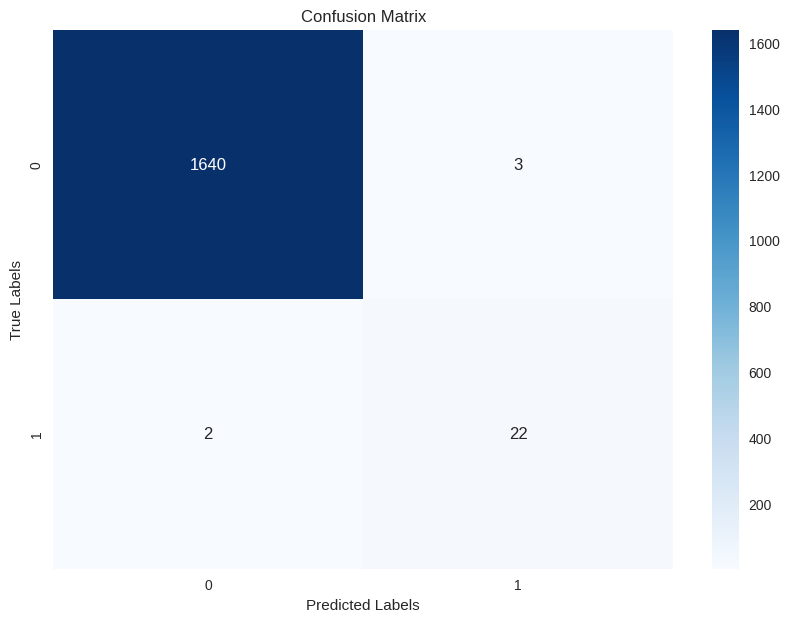

Accuracy: 0.997000599880024
Kappa: 0.8964377570418598
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1643
         1.0       0.88      0.92      0.90        24

    accuracy                           1.00      1667
   macro avg       0.94      0.96      0.95      1667
weighted avg       1.00      1.00      1.00      1667



In [ ]:
trueLabels = rfTestingPred['is_champion']
predictedLabels = rfTestingPred['prediction_label']

conf_matrix = confusion_matrix(trueLabels, predictedLabels)

pltfigure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calcular acurácia
accuracy = accuracy_score(trueLabels, predictedLabels)

# Calcular coeficiente Kappa
kappa = cohen_kappa_score(trueLabels, predictedLabels)

# Gerar relatório de classificação
classification_rep = classification_report(trueLabels, predictedLabels)

# Exibir as métricas
print(f'Accuracy: {accuracy}')
print(f'Kappa: {kappa}')
print('Classification Report:')
print(classification_rep)

In [ ]:
# Tunando o modelo
tunedRf = tune_model(rfModel)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9940,0.9982,1.0000,0.7500,0.8571,0.8541,0.8634
1,0.9925,0.9982,1.0000,0.7059,0.8276,0.8239,0.8370
2,0.9760,0.8797,0.7692,0.4348,0.5556,0.5442,0.5677
3,0.9865,0.9956,1.0000,0.5909,0.7429,0.7364,0.7634
4,0.9925,0.9975,1.0000,0.7222,0.8387,0.8350,0.8466
5,0.9940,0.9605,0.9231,0.8000,0.8571,0.8541,0.8564
6,0.9925,0.9978,1.0000,0.7059,0.8276,0.8239,0.8370
7,0.9955,0.9992,1.0000,0.8000,0.8889,0.8866,0.8924
8,0.9880,0.9969,1.0000,0.6000,0.7500,0.7442,0.7698


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


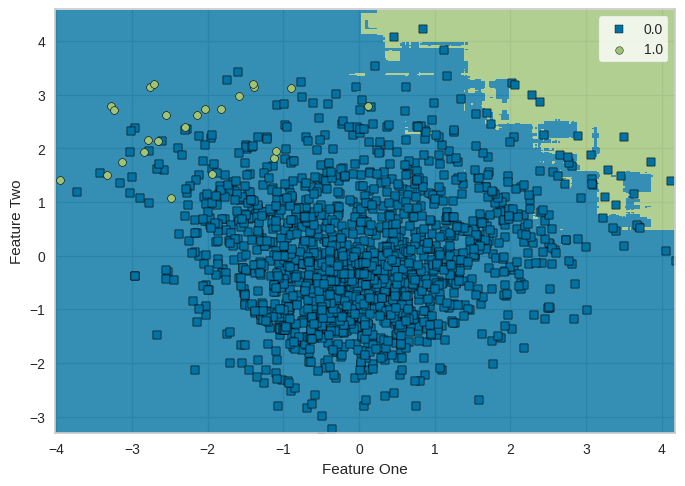

In [ ]:
plot_model(tunedRf, plot = 'boundary')

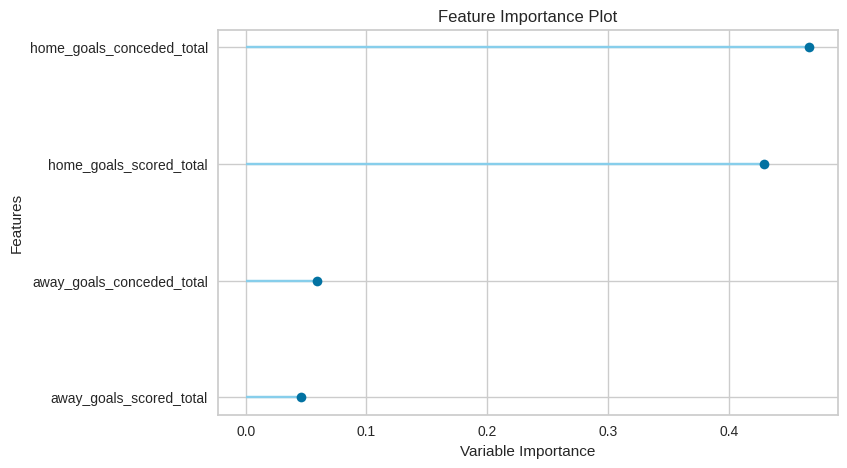

In [ ]:
plot_model(tunedRf, plot = 'feature')

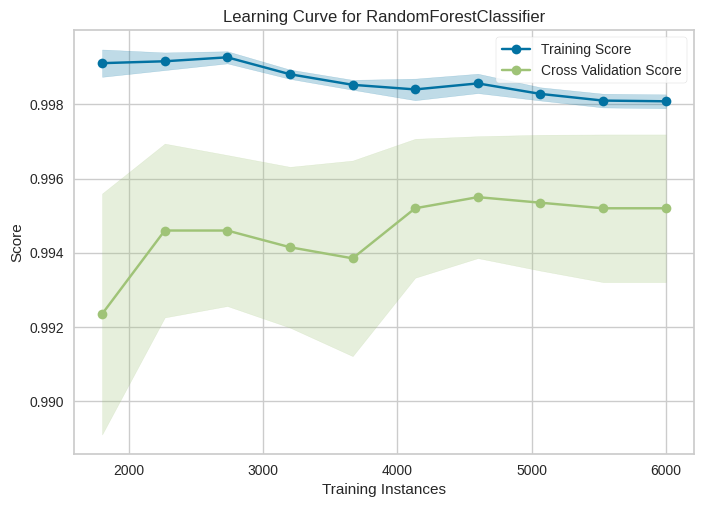

In [ ]:
plot_model(tunedRf, plot = 'learning')

In [ ]:
#Realizar predição do modelo tunado
tunedTfTestingPred = predict_model(tunedRf, data=X_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9970,0.9998,0.9167,0.8800,0.8980,0.8964,0.8966


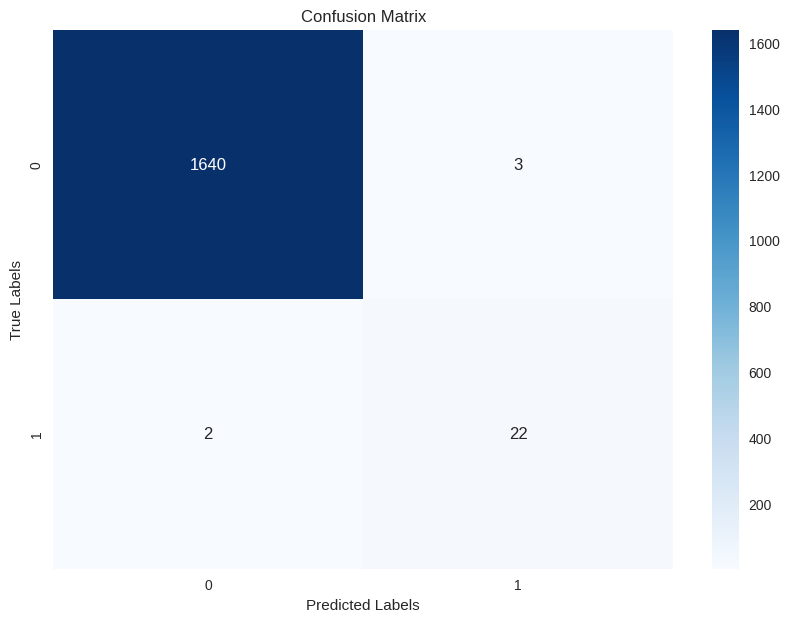

Accuracy: 0.997000599880024
Kappa: 0.8964377570418598
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1643
         1.0       0.88      0.92      0.90        24

    accuracy                           1.00      1667
   macro avg       0.94      0.96      0.95      1667
weighted avg       1.00      1.00      1.00      1667



In [ ]:
tunedTrueLabels = tunedTfTestingPred['is_champion']
tunedPredictedLabels = tunedTfTestingPred['prediction_label']

conf_matrix = confusion_matrix(tunedTrueLabels, tunedPredictedLabels)

pltfigure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calcular acurácia
accuracy = accuracy_score(tunedTrueLabels, tunedPredictedLabels)

# Calcular coeficiente Kappa
kappa = cohen_kappa_score(tunedTrueLabels, tunedPredictedLabels)

# Gerar relatório de classificação
classification_rep = classification_report(tunedTrueLabels, tunedPredictedLabels)

# Exibir as métricas
print(f'Accuracy: {accuracy}')
print(f'Kappa: {kappa}')
print('Classification Report:')
print(classification_rep)

In [ ]:
# Para o modelo k-nn
knnModel = create_model('knn', n_neighbors=5, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9745,0.8852,0.3200,0.3200,0.3200,0.3070,0.3070
1,0.9790,0.9619,0.3333,0.4000,0.3636,0.3530,0.3546
2,0.9835,0.9516,0.3200,0.6154,0.4211,0.4135,0.4365
3,0.9782,0.9474,0.1600,0.3333,0.2162,0.2066,0.2210
4,0.9805,0.9684,0.2800,0.4667,0.3500,0.3407,0.3522
Mean,0.9791,0.9429,0.2827,0.4271,0.3342,0.3242,0.3343
Std,0.0029,0.0298,0.0639,0.1077,0.0675,0.0681,0.0704


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

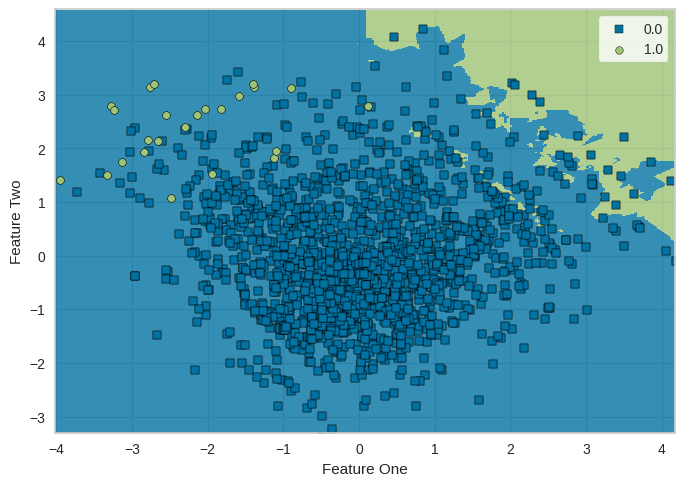

In [ ]:
plot_model(knnModel, plot = 'boundary')

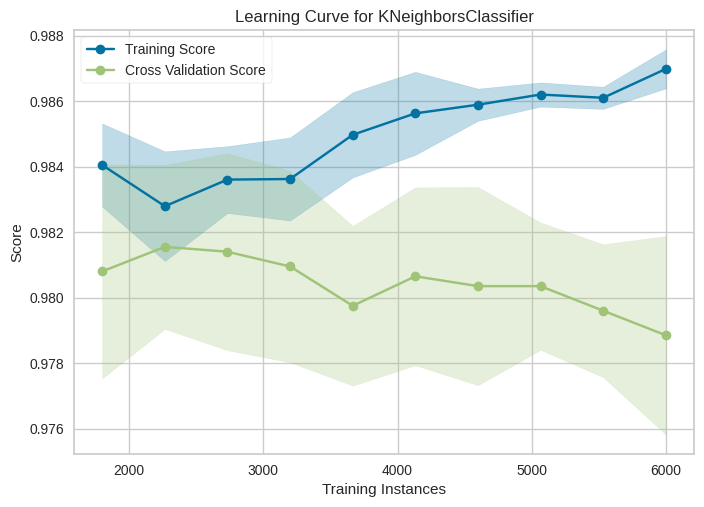

In [ ]:
plot_model(knnModel, plot = 'learning')

In [ ]:
knnTestingPred = predict_model(knnModel, data = X_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9862,0.9490,0.5000,0.5217,0.5106,0.5036,0.5038


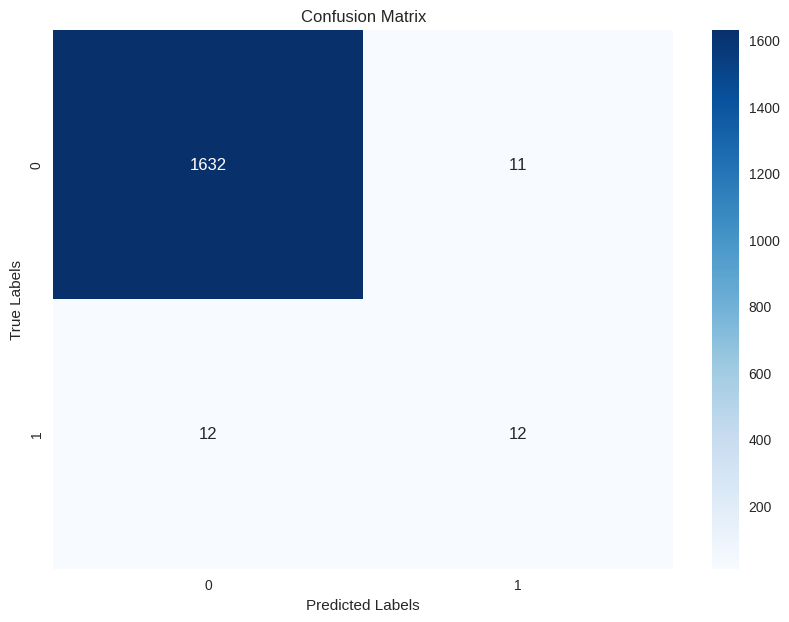

Accuracy: 0.9862027594481104
Kappa: 0.5036442488186937
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1643
         1.0       0.52      0.50      0.51        24

    accuracy                           0.99      1667
   macro avg       0.76      0.75      0.75      1667
weighted avg       0.99      0.99      0.99      1667



In [ ]:
# Supondo que 'true_labels' seja a coluna de rótulos verdadeiros e 'predicted_labels' a coluna de rótulos previstos
knnTrueLabels = knnTestingPred['is_champion']
knnPredictedLabels = knnTestingPred['prediction_label']

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(knnTrueLabels, knnPredictedLabels)

# Plotar a matriz de confusão
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calcular acurácia
accuracy = accuracy_score(knnTrueLabels, knnPredictedLabels)

# Calcular coeficiente Kappa
kappa = cohen_kappa_score(knnTrueLabels, knnPredictedLabels)

# Gerar relatório de classificação
classification_rep = classification_report(knnTrueLabels, knnPredictedLabels)

# Exibir as métricas
print(f'Accuracy: {accuracy}')
print(f'Kappa: {kappa}')
print('Classification Report:')
print(classification_rep)